# Kendall rank correlation coefficient (Kendall's tau)

In statistics, the [Kendall rank correlation coefficient](https://en.wikipedia.org/wiki/Kendall_rank_correlation_coefficient), commonly referred to as Kendall's tau (τ), is a statistic used to measure the ordinal association between two measured quantities. A **T test** is a [non-parametric](https://en.wikipedia.org/wiki/Non-parametric_statistics) [hypothesis test](https://en.wikipedia.org/wiki/Hypothesis_test) for statistical dependence based on the $T$ coefficient. It is a measure of [rank correlation](https://en.wikipedia.org/wiki/Rank_correlation): the similarity of the orderings of data when ranked by each of the quantities. It is named after [Maurice Kendall](https://en.wikipedia.org/wiki/Maurice_Kendall), who developed it in 1938, though Gustav Fechner has proposed a similar measure in the context of time series in 1897. 

Kendall's motification was to create a rubust, intuitive measure of association between two rankings--one that was:
 - non parameteric -- meaning it made no assumptions about the distribution of the data
 - intuative in interpretation -- meaning it could be easily understood (based on concordant and discordant pairs) and
 - suitable for ordinal or ranked data (like preferences, ratings, or scores).

 Before Kendall's tau, other correlation measures like [Pearson's correlation coefficient](https://en.wikipedia.org/wiki/Pearson_correlation_coefficient) were commonly used, but they assumed linear relationships and required interval or ratio data. Kendall's tau provided a way to assess relationships in a more flexible manner, especially for non-linear or non-parametric data.

 In many real-world problems, especially in decision analysis (also social sciences) data are often ordinal -- things we can rank but not measure on a precise numerical scale.

 For example: a hydrologist looking to build a groundwater recharge project, might want to rank potential sites based on suitability critiera, and rank them in suitability from 1 (low suitability) to 5 or 10 (high suitability). Kendall's tau would allow the hydrologist to assess the association between different ranking criteria (like soil type, proximity to water sources, land use, etc.) without making assumptions about the underlying data distribution.

 ## How it works 

 Imagine two people rank the same set of sites independently based on their expert opinion of suitability for groundwater recharge.

 site   | Rater A Rank | Rater B Rank
 ------ | ------------ | ------------ 
    S1  | 1            | 2
    S2  | 2            | 1
    S3  | 3            | 4
    S4  | 4            | 3
    S5  | 5            | 5

Kendall’s tau looks at **all possible pairs of sites** (S1 vs S2, S1 vs S3, … S4 vs S5) and asks:
- Do the two analysts agree on which site should be ranked higher?

For any pair of sites $(i, j)$:
- The pair is **concordant** if both analysts put the same site higher.  
  (Example: if $A$ says $S2$ better than $S5$, and $B$ also says $S2$ better than $S5$.)
- The pair is **discordant** if the analysts disagree about which one is better.  
  (Example: A says $S1$ better than $S4$, but $B$ says $S4$ better than $S1$.)
- (Ties are possible in general, though not shown in this simple example. We handle those with slight variations of tau.)

Intuition:
- If most pairs are concordant → $\tau$ is close to +1 (the rankings mostly agree).
- If most pairs are discordant → $\tau$ is close to −1 (the rankings mostly disagree / almost inverted).
- If agreement and disagreement are about equal → $\tau$ is near 0.

---

## The "probability" view

One clean way to define Kendall’s tau is:

$$
\tau = P(\text{concordant}) - P(\text{discordant})
$$

Here $P(\text{concordant})$ means:  
“Out of all possible pairs of items, what fraction of pairs are concordant?”

In other words, these are not probabilities in the sense of randomness over repeated experiments — they are proportions over all $\frac{n(n-1)}{2}$ pairs in *this* dataset.

So you can read $\tau$ as:
> “If I pick two items at random, how much more likely is it that the two rankings agree on their order than disagree?”

That’s the core interpretation.

---

## The counting (pairwise) formula

Let:
- $n$ = number of items being ranked  
- $C$ = number of concordant pairs  
- $D$ = number of discordant pairs  
- $T = \frac{n(n-1)}{2}$ = total number of distinct pairs

Then Kendall’s tau can be written as:

$$
\tau = \frac{C - D}{T}
= \frac{C - D}{\frac{1}{2} n (n - 1)}
$$

This is the same as the “probability” version, just written in terms of counts instead of proportions:
- $\frac{C}{T}$ is $P(\text{concordant})$
- $\frac{D}{T}$ is $P(\text{discordant})$

So:
$$
\tau = \frac{C}{T} - \frac{D}{T}
$$

---

In practice, we’ll compute $C$ and $D$ from two ranked lists, calculate $\tau$, and then visualize where disagreements are happening spatially or across alternatives.

Next, we’ll implement this calculation in Python, both “by hand” (to see C and D) and using `scipy.stats.kendalltau`.

> Now lets explore how to calculate Kendall's tau using Python.

In [1]:
# import pandas to create an manipulate dataframes
import pandas as pd

# create a sample dataframe with rankings from two analysts
data = pd.DataFrame({
    "Site": ["A", "B", "C", "D", "E", "F"],
    "Rank_Analyst1": [1, 2, 3, 4, 5, 6],  # Analyst 1 thinks A>B>C>D>E>F
    "Rank_Analyst2": [1, 3, 2, 4, 6, 5]   # Analyst 2 mostly agrees, but swaps B/C and E/F
})

data

,Site,Rank_Analyst1,Rank_Analyst2
0,A,1,1
1,B,2,3
2,C,3,2
3,D,4,4
4,E,5,6
5,F,6,5


> Ok, now lets create a function that checks all possible pairings rankings to determine concordant (agreeing) and discordant (disagreeing) pairs. 

In [2]:
# itertools is a useful library for creating combinations and permutations
import itertools

def kendall_concordance_table(df, col_x, col_y):
    """
    Create a table showing concordant and discordant pairs between two rankings.
    df: DataFrame with rankings
    col_x: column name for first ranking
    col_y: column name for second ranking
    Returns a DataFrame with pairwise comparisons and counts of concordant/discordant pairs.
    """
    pairs_info = [] # to store info about each pair
    C = 0  # concordant = they agree on order
    D = 0  # discordant = they disagree on order
    for (i, j) in itertools.combinations(df.index, 2): # for all unique pairs of indices (i, j)
        x_i = df.loc[i, col_x] # x_i is the rank of item i in ranking x
        x_j = df.loc[j, col_x] # x_j is the rank of item j in ranking x
        y_i = df.loc[i, col_y] # y_i is the rank of item i in ranking y
        y_j = df.loc[j, col_y] # y_j is the rank of item j in ranking y
        site_i = df.loc[i, "Site"] # get site names for reporting for item i
        site_j = df.loc[j, "Site"] # get site names for reporting for item j

        # Compare pair ordering in each ranking
        diff_x = x_i - x_j # difference in ranking for pair (i, j) in ranking x
        diff_y = y_i - y_j # difference in ranking for pair (i, j) in ranking y

        # If both differences have same sign -> concordant
        # If opposite sign -> discordant
        # If diff_x or diff_y == 0, that's a tie (we'll just mark it)
        if diff_x * diff_y > 0:
            relation = "concordant"
            C += 1
        elif diff_x * diff_y < 0:
            relation = "discordant"
            D += 1
        else:
            relation = "tie"

        pairs_info.append({
            "Pair": f"{site_i}-{site_j}",
            f"Order in {col_x}": "i<j" if diff_x < 0 else "i>j",
            f"Order in {col_y}": "i<j" if diff_y < 0 else "i>j",
            "Relation": relation
        })

    pairs_df = pd.DataFrame(pairs_info)
    return pairs_df, C, D

# Now let's use the function on our sample data
pairs_df, C, D = kendall_concordance_table(data, "Rank_Analyst1", "Rank_Analyst2")
print(f"Concordant pairs (C): {C}, Discordant pairs (D): {D}") # print out the counts of concordant and discordant pairs
pairs_df # print the output table from the function: kendall_concordance_table()

Concordant pairs (C): 13, Discordant pairs (D): 2


,Pair,Order in Rank_Analyst1,Order in Rank_Analyst2,Relation
0,A-B,i<j,i<j,concordant
1,A-C,i<j,i<j,concordant
2,A-D,i<j,i<j,concordant
3,A-E,i<j,i<j,concordant
4,A-F,i<j,i<j,concordant
5,B-C,i<j,i>j,discordant
6,B-D,i<j,i<j,concordant
7,B-E,i<j,i<j,concordant
8,B-F,i<j,i<j,concordant
9,C-D,i<j,i<j,concordant


## Compute Kendall's Tau from first principles

Next we will compute Kendall's tau manually using Python.

*remember that tau is the difference between the probability of concordant and discordant pairs.*

For $n$ items, the total number of distince pairs is given by the formula: $T = \frac{n(n-1)}{2}$.

Then, we can use the output of the function above which counted the number of concordant and discordant pairs to compute kendall's tau.

In [3]:
import numpy as np # for numerical operations we use numpy

n = len(data) # number of items being ranked
total_pairs = n * (n - 1) / 2 # total number of distinct pairs T
tau_manual = (C - D) / total_pairs # Kendall's tau formula

print(f" C = {C}, D = {D}, Total pairs (T): {total_pairs}")
print(f"Kendall's tau (manual calculation): {tau_manual:.3f}")

 C = 13, D = 2, Total pairs (T): 15.0
Kendall's tau (manual calculation): 0.733


> Interpreting the results

if tau is close to +1, the rankings mostly agree
if tau is close to 0.5, mostly agree but with notable flips
if tau is close to -1, the rankings mostly disagree
if tau is close to -0.5, mostly disagree but with agreements
if tau is close to 0, there is little association between the rankings

For this synthetic dataset we should see $\tau$ as high but not 1 because those B vs C and E vs F swaps create discordance.

> Next lets visualize the agreement and disagreement between the two rankings.

To do this we will plot...

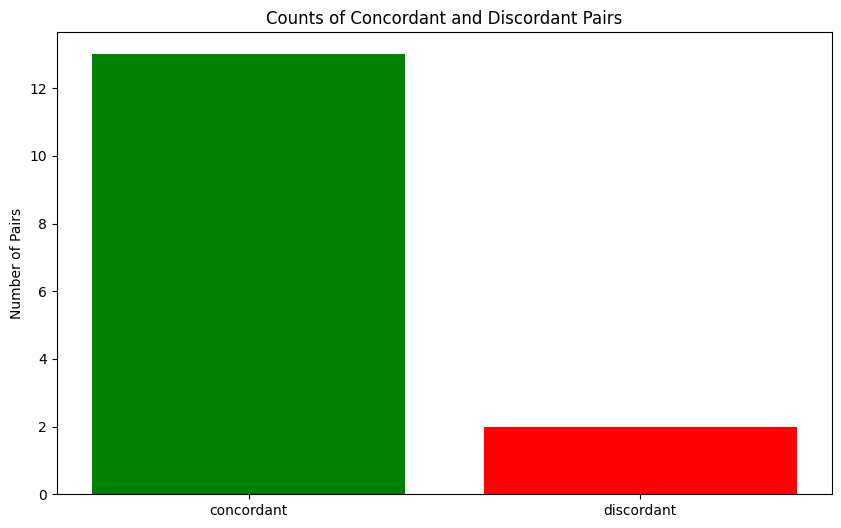

In [4]:
import matplotlib.pyplot as plt

color_map = { 'concordant': 'green', 'discordant': 'red', "tie": 'gray' }

plt.figure(figsize=(10, 6))
pair_counts = pairs_df["Relation"].value_counts()
bars = plt.bar(pair_counts.index, pair_counts.values,
               color=[color_map[r] for r in pair_counts.index])

plt.ylabel("Number of Pairs")
plt.title("Counts of Concordant and Discordant Pairs")
plt.show()

So looking at the figure we can see that most of the pairs are concordant, we have a few discordant pairs (in red) and no ties (gray). We got a kendall's tau of 0.733 which indicates a strong positive association between the two rankings.

## Compare manual calculation to scipy.stats

Now that we understand the basic calculation of Kendall's tau, lets try to use the scipy.stats version of kendall's tau to see if we get the same results and how our manual calculation compares to the built-in function in scipy.stats 

In [5]:
from scipy.stats import kendalltau # import kendalltau from scipy.stats

# recall the structure of our data
print(data.columns) # show column names
data.head(5) # show first 5 rows of data

Index(['Site', 'Rank_Analyst1', 'Rank_Analyst2'], dtype='object')


,Site,Rank_Analyst1,Rank_Analyst2
0,A,1,1
1,B,2,3
2,C,3,2
3,D,4,4
4,E,5,6


In [6]:
tau_scipy, p_value = kendalltau(data["Rank_Analyst1"], data["Rank_Analyst2"])
print(f"Kendall's tau (scipy.stats): {tau_scipy:.3f}, p-value: {p_value:.3f}")

Kendall's tau (scipy.stats): 0.733, p-value: 0.056


Notice that both our manual calculation and scipy's kendalltau function give the same result of approximately 0.733, confirming the correctness of our manual implementation. But the scipy function also provides a p-value for testing the hypothesis of no association ($\tau = 0$)

So the scipy version does two things:
    
1. It computes Kendall's tau using an efficient algorithm measuring the strength of [monotonic](https://en.wikipedia.org/wiki/Monotonic_function) association between two rankings.
2. It provides a p-value for testing the null hypothesis that there is no association between the two rankings (i.e., $\tau = 0$). A low p-value (typically < 0.05) indicates that we can reject the null hypothesis and conclude that there is a statistically significant association between the rankings.

Here we got a p-value of approximately 0.056, which indicates that the association is marginally significant at the 0.05 level. This suggests that while there is a positive association between the rankings, we should be cautious in interpreting it as statistically significant. Why? Because our sample dataset is small (only 5 items), with a such a small number of pairs its more likely that random chance could produce similar levels of concordance. lets see what happens when we increase the size of the dataset.

## Adding complexity

To further explore the behavior of Kendall's tau, we can increase the size of our dataset from 6 sites to 30. We will randomly generate base ranking, then create a slightly "noisy" version to simulate small differences in judgement or weight perturbations.




Kendall's tau between Analyst A and B: 0.593, p-value: 0.000


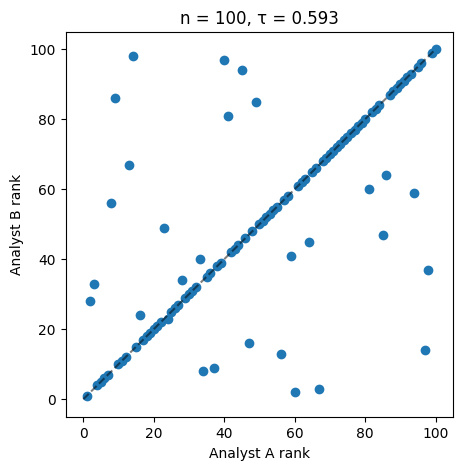

In [7]:
np.random.seed(32)  # for reproducibility
n = 100 # change this and re-run as well to see the effect of sample size 
swap_n = 30 # number of swaps to introduce, change this value and re-run to see different levels of disagreement

# Analyst A: perfect ranking 1 -> n
rank_A = np.arange(1, n + 1) # Analyst A ranks items from 1 to n

# Analyst B: same order bit with some random swaps (simulateing disagreement)
rank_B = rank_A.copy() # start with same ranking as Analyst A
swap_indices = np.random.choice(n, size=swap_n, replace=False) # choose 5 random indices to swap
np.random.shuffle(swap_indices) # shuffle the selected indices
rank_B[swap_indices] = rank_B[np.random.permutation(swap_indices)]  # perform the swaps

tau, p_value = kendalltau(rank_A, rank_B)
print(f"Kendall's tau between Analyst A and B: {tau:.3f}, p-value: {p_value:.3f}")

# Visualize the rankings in a scatter plot
plt.figure(figsize=(5,5))
plt.scatter(rank_A, rank_B)
plt.plot([0,n],[0,n],'k--',alpha=0.5)
plt.xlabel("Analyst A rank")
plt.ylabel("Analyst B rank")
plt.title(f"n = {n}, τ = {tau:.3f}")
plt.show()



> Next lets add noise a different way.

First we will create a set of data, we will call *base_scores* we will just take $n$ numbers spaced equally from 0 to 1

then we will create alternative scores which are the base_scores with some noise added, noise from a random normal distribution.



In [8]:

n = 19 # change this depending on the sample size you want
noise_factor = 0.08 # this is the standard devation of the distribution from which the noise is generated, try 0.1, 0.05, 1, see how this affects kendalls tau
base_scores = np.linspace(0,1,n)
#print(f"base_scores {base_scores}")

noise = np.random.normal (0,noise_factor,n) # create noise by drawing random samples from a normal gaussian distribution

alt_scores = base_scores + noise # add the noise to the base scores to create alternative scores
#print(f"alt scores (base scores + noise) {alt_scores}")

rank_base = pd.Series(base_scores).rank() # rank the original scores, (remember we want ranks not scores)
rank_alt = pd.Series(alt_scores).rank() # the base scores have been changed a bit randomly so they will rank differently when their rank is calculated

# now lets calculate kendall's tau

tau, p_value = kendalltau(rank_base, rank_alt)
print(f"τ = {tau:.3f}; pvalue = {p_value:.5f}")

τ = 0.860; pvalue = 0.00000


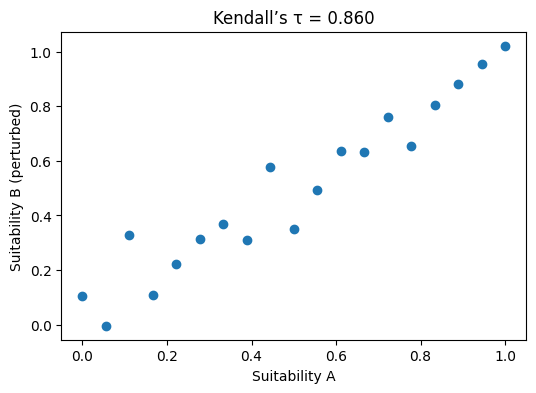

In [9]:
# plot the relationship between rank_base, and rank_alt (our two different rankings)

plt.figure(figsize=(6,4))
plt.scatter(base_scores, alt_scores)
plt.xlabel("Suitability A")
plt.ylabel("Suitability B (perturbed)")
plt.title(f"Kendall’s τ = {tau:.3f}")
plt.show()

> Lets now look at how changing the level of noise in the data affects the kendalls tau

We will generate many random pertubations and compute $\tau$ each time. This mimics the way sensitivity analysis samples random weight combinations in a Weighted Linear Combination (WLC). basically we are looking at the kendall's tau through time, and automating the changing of the standard devation within the noise addition to see how adding different levels of noise affects kendall's tau. 

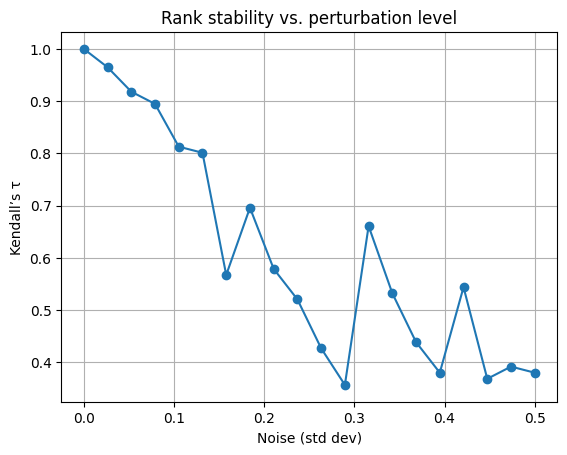

In [10]:

noise_levels = np.linspace(0,0.5,20)
#print(noise_levels)

taus = []

for s in noise_levels:
    alt = base_scores + np.random.normal(0 , s , n) # recall n is defined above in previous example as is base_scores
    taus.append(kendalltau(pd.Series(base_scores).rank(), pd.Series(alt).rank())[0])


plt.plot(noise_levels, taus, marker='o')
plt.xlabel("Noise (std dev)")
plt.ylabel("Kendall’s τ")
plt.title("Rank stability vs. perturbation level")
plt.grid(True)
plt.show()

> you can see from the above figure that as noise increases kendall's tau a measure of similarity between rankings decreases, rank stability decreases.

## real-world example - Countries Ranked by Life Expectency and GDP

Ok, enough with fake data sets, lets step away from the hard sciences for a second and look at something more social. Lets look at how life expectancy compares to GDP, we would think life expectancy is higher in rich countries and lower in poor countries. So we can get the data on life expectancy, and we can get the data on GDP, then rank the countries in order of GDP and life expectancy, and compare how these two different ways to rank countries are concordant or discordant using Kendalls Tau

> to see how we cleaned and created these datasets see this notebook: `Data\DataWranglingScripts\GDPvLifeExpectency2022_countries_ranked.ipynb`



In [11]:
df = pd.read_csv("../Data/CLEAN/GDP_LifeExpectancy_2022_Clean.csv")
print(df.head())
print(df.columns)


                  Country Name Country Code   GDP_PC_2022  LIFE_EX_YRS_2022  \
0                        Aruba          ABW  30559.533535         73.537000   
1  Africa Eastern and Southern          AFE   1628.318944         61.765707   
2                  Afghanistan          AFG    357.261153         63.941000   
3   Africa Western and Central          AFW   1796.668633         56.906135   
4                       Angola          AGO   2929.694455         61.748000   

   GDP_PC_RANK_2022  LIFE_EX_YRS_RANK_2022  
0              56.0                   86.0  
1             216.0                  220.0  
2             255.0                  203.0  
3             210.0                  251.0  
4             187.0                  221.0  
Index(['Country Name', 'Country Code', 'GDP_PC_2022', 'LIFE_EX_YRS_2022',
       'GDP_PC_RANK_2022', 'LIFE_EX_YRS_RANK_2022'],
      dtype='object')


In [12]:
tau, pval = kendalltau(df["GDP_PC_RANK_2022"], df["LIFE_EX_YRS_RANK_2022"])

print(f"Kendall's tau (τ) = {tau:.3f}")
print(f"p-value = {pval:.8f}")

Kendall's tau (τ) = 0.651
p-value = 0.00000000


We see a strong positive rank correlation, which is what we would expect. Wealthier countries generally have longer life expectancy, though the relationship isnt perfect. Now lets visualize the data.

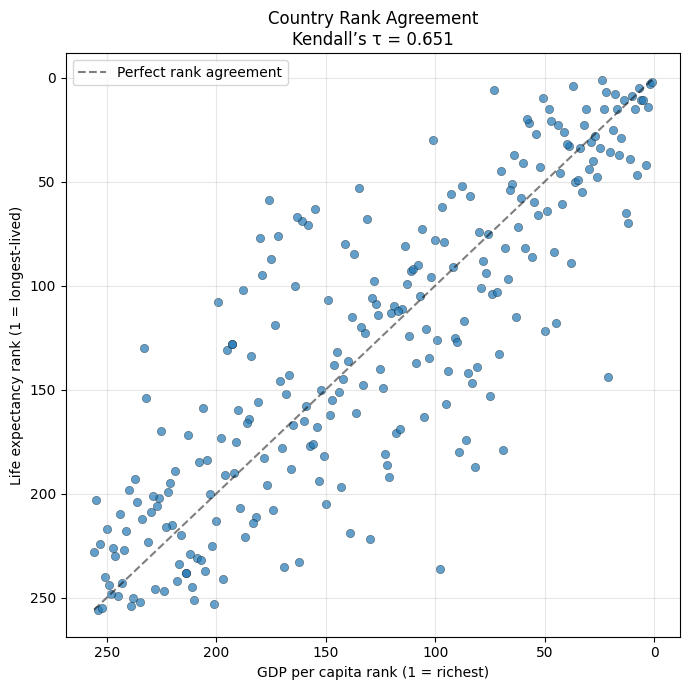

In [13]:
plt.figure(figsize=(7,7))
plt.scatter(
    df["GDP_PC_RANK_2022"],
    df["LIFE_EX_YRS_RANK_2022"],
    alpha=0.7,
    edgecolor="k",
    linewidth=0.3
)

# Add a diagonal "perfect agreement" line
plt.plot(
    [1, df["GDP_PC_RANK_2022"].max()],
    [1, df["LIFE_EX_YRS_RANK_2022"].max()],
    'k--', alpha=0.5, label="Perfect rank agreement"
)

plt.xlabel("GDP per capita rank (1 = richest)")
plt.ylabel("Life expectancy rank (1 = longest-lived)")
plt.title(f"Country Rank Agreement\nKendall’s τ = {tau:.3f}")

# Flip axes so 'better' (rank 1) appears top-right
plt.gca().invert_xaxis()
plt.gca().invert_yaxis()
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

Next we will zoom in on the top 40 countries in terms of GDP and see if the kendalls tau is better or worse when we exclude all but the 40 richest. 

In [14]:
# Sort by GDP rank (1 = richest)
df_top40 = (
    df
    .sort_values("GDP_PC_RANK_2022", ascending=True)
    .head(40)
    .copy()
)

print(df_top40[["Country Name", "GDP_PC_RANK_2022", "LIFE_EX_YRS_RANK_2022"]].head())
print(f"Number of countries in subset: {len(df_top40)}")

      Country Name  GDP_PC_RANK_2022  LIFE_EX_YRS_RANK_2022
144         Monaco               1.0                    2.0
133  Liechtenstein               2.0                    3.0
140     Luxembourg               3.0                   14.0
27         Bermuda               4.0                   42.0
172         Norway               5.0                   11.0
Number of countries in subset: 40


In [15]:
tau_top, pval_top = kendalltau(
    df_top40["GDP_PC_RANK_2022"],
    df_top40["LIFE_EX_YRS_RANK_2022"]
)

print(f"Kendall’s τ (top 40 richest) = {tau_top:.3f}")
print(f"p-value = {pval_top:.8f}")

Kendall’s τ (top 40 richest) = 0.248
p-value = 0.02515424


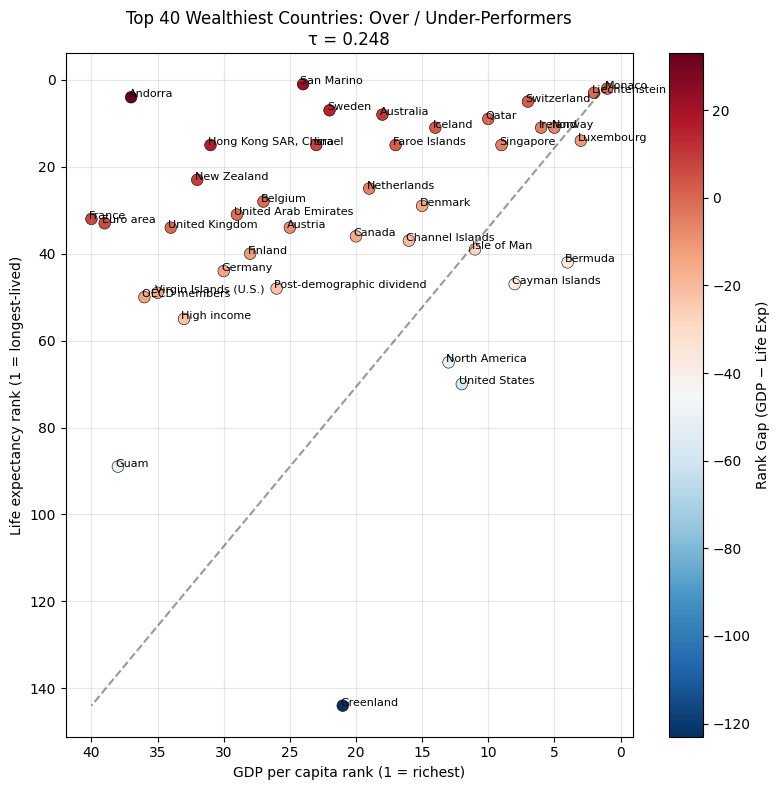

In [16]:
df_top40["RankGap"] = (
    df_top40["GDP_PC_RANK_2022"] - df_top40["LIFE_EX_YRS_RANK_2022"]
)

plt.figure(figsize=(8,8))
scatter = plt.scatter(
    df_top40["GDP_PC_RANK_2022"],
    df_top40["LIFE_EX_YRS_RANK_2022"],
    c=df_top40["RankGap"],
    cmap="RdBu_r",
    s=70,
    edgecolor="k",
    linewidth=0.4
)
plt.colorbar(scatter, label="Rank Gap (GDP − Life Exp)")

plt.plot(
    [1, df_top40["GDP_PC_RANK_2022"].max()],
    [1, df_top40["LIFE_EX_YRS_RANK_2022"].max()],
    'k--', alpha=0.4
)

for _, row in df_top40.iterrows():
    plt.text(
        row["GDP_PC_RANK_2022"] + 0.2,
        row["LIFE_EX_YRS_RANK_2022"],
        row["Country Name"],
        fontsize=8
    )

plt.xlabel("GDP per capita rank (1 = richest)")
plt.ylabel("Life expectancy rank (1 = longest-lived)")
plt.title(f"Top 40 Wealthiest Countries: Over / Under-Performers\nτ = {tau_top:.3f}")

plt.gca().invert_xaxis()
plt.gca().invert_yaxis()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

The analysis of country rank in terms of GDP per capita vs life expectancy using Kendall's tau tells us that overall life expectency is correlated with GDP per capita in terms of how contries compare to eachother (rank), however the correlation is much worse in the rich countries, why might that be? 

## CONCEPTUAL QUESTIONS

1. Is Kendall's Tau a good way to measure the correlation of these two variables?

> answer: Its more approriate to look at how the Life Expectency values compare to the GDP per capita directly using Pearson's R, which compares one number to another. Kendall's Tau is for comparing the ranks, so the colored rank figure shows us that countries below the line, are under performing in terms of life expectancy vs GDP relative to their neighbors. It is also telling us the the GDP life expectency relationship breaks down at higher levels of GDP or is less meaningful. 

2. Why might this relationship breakdown when subsetting the data to only the richest countries?

## Spatial Rank Correlation

> Using Kendalls Tau for suitability mapping sensitivity Analysis 

In a Weighted Linear Combination (WLC) or other GIS-MCDA, you often generate suitability rasters under different weighting schemes, e.g.:

- Scenario A: baseline weights (e.g., 40% slope, 30% soil, 30% rainfall)

- Scenario B: modified weights (e.g., 30% slope, 40% soil, 30% rainfall)

Each raster cell gets a suitability score.
You can rank cells (1 = most suitable) for each scenario, then compute Kendall’s $\tau$ between the two rankings.

## simulated MCDA suitability

We will build two small 10x10 rasteres (100 cells):

suitability_A --> Baseline Scenario
suitability_B --> slightly perturbed version (change one weight layer)

1. Then flatted both to 1D arrays (each cell = one observation)

2. compute $\tau$ for the full map

3. visualize where ranks changed the most.


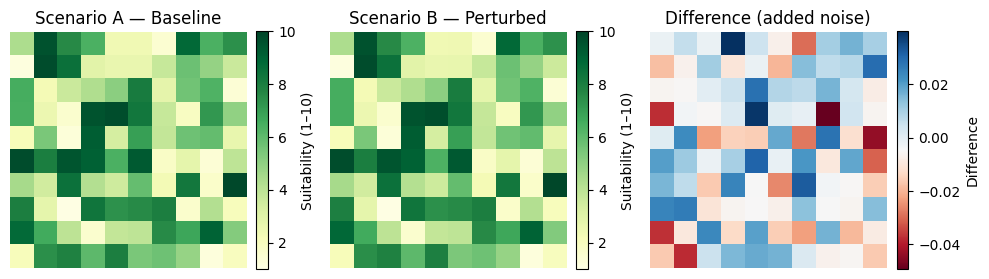

In [49]:
np.random.seed(42)

# --- Step 1: create two synthetic suitability grids (values 1–10) ---
grid_size = 10
suitability_A = np.random.rand(grid_size, grid_size) * 9 + 1  # values in [1,10]
suitability_B = suitability_A + np.random.normal(0, 0.02, (grid_size, grid_size))  # add mild noise
suitability_B = np.clip(suitability_B, 1, 10)  # keep within same range

diff = suitability_A - suitability_B

# --- Step 2: plot them side-by-side ---
fig, axes = plt.subplots(1, 3, figsize=(10, 4))

im1 = axes[0].imshow(suitability_A, cmap="YlGn", vmin=1, vmax=10)
axes[0].set_title("Scenario A — Baseline")
axes[0].axis("off")
plt.colorbar(im1, ax=axes[0], fraction=0.046, pad=0.04, label="Suitability (1–10)")

im2 = axes[1].imshow(suitability_B, cmap="YlGn", vmin=1, vmax=10)
axes[1].set_title("Scenario B — Perturbed")
axes[1].axis("off")
plt.colorbar(im2, ax=axes[1], fraction=0.046, pad=0.04, label="Suitability (1–10)")

im3 = axes[2].imshow(diff, cmap = 'RdBu', vmin = diff.min(), vmax = diff.max())
axes[2].set_title("Difference (added noise)")
axes[2].axis('off')
plt.colorbar(im3, ax=axes[2], fraction=0.046, pad = 0.04, label="Difference")

plt.tight_layout()
plt.show()

In [50]:
# --- Step 3: compute Kendall’s tau on the flattened ranks ---
A_flat = suitability_A.flatten()
B_flat = suitability_B.flatten()

rank_A = pd.Series(A_flat).rank()
rank_B = pd.Series(B_flat).rank()

tau, pval = kendalltau(rank_A, rank_B)
print(f"Overall spatial Kendall’s τ = {tau:.3f} -- Pvalue: {pval:.4f}")

Overall spatial Kendall’s τ = 0.997 -- Pvalue: 0.0000


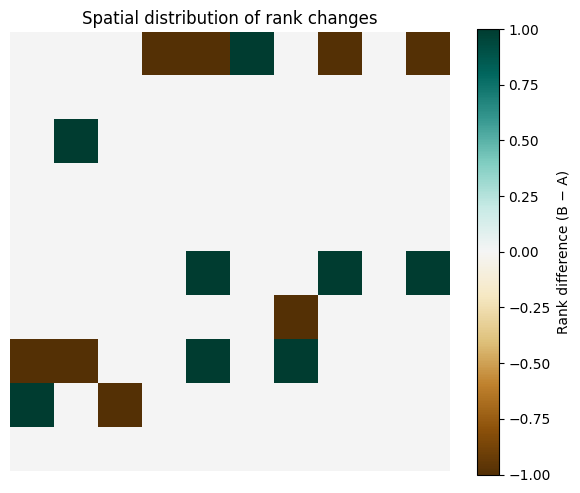

In [51]:
rank_diff = (rank_B - rank_A).values.reshape(grid_size, grid_size)

plt.figure(figsize=(6,5))
plt.imshow(rank_diff, cmap="BrBG", vmin=rank_diff.min(), vmax=rank_diff.max())
plt.colorbar(label="Rank difference (B − A)")
plt.title("Spatial distribution of rank changes")
plt.axis("off")
plt.tight_layout()
plt.show()